## Description

Необходимо помесячно предсказать объем продаж квартир в квадратных метрах на февраль, март, апрель 2018г. Предсказание делается для каждого сета - набора квартир из одного корпуса (id_bulk), с одинаковой комнатностью (spalen). 

Публичный рейтинг строится на основе 75% test-сета. Финальный рейтинг по 100% test-сета будет построен после завершения публичной части соревнования и появится в разделе «Результаты». Метрика оценки качества решения - RMSE.

- **train.csv**
Тренировочный датасет, в каждой строчке в поле value указан объем продаж в квадратных метрах в соответствующий месяц по соответствующему сету.
- **test.csv**
Тестовый датасет, предсказание необходимо сделать по каждому сету на февраль, март, апрель 2018г. По сравнению с train в test нет полей: start_square, plan_s, plan_m, plan_l, vid_0, vid_1, vid_2. Данные поля удалены т.к. могут быть некорректно использованы при расчет объема продаж в прошлом месяце в тестовом периоде.
- **flat.csv**
Параметры всех квартир, в поле sale указана дата продажи квартиры (кроме test периода), для непроданных квартир за train период в поле sale указан 01.01.2020г.
- **status.csv**
История изменения статусов по каждой квартире (кроме test периода). Информация о резервах может быть очень полезна для предсказания первого месяца тестового периода.
- **price.csv**
История изменения цены по каждой квартире (кроме test периода)

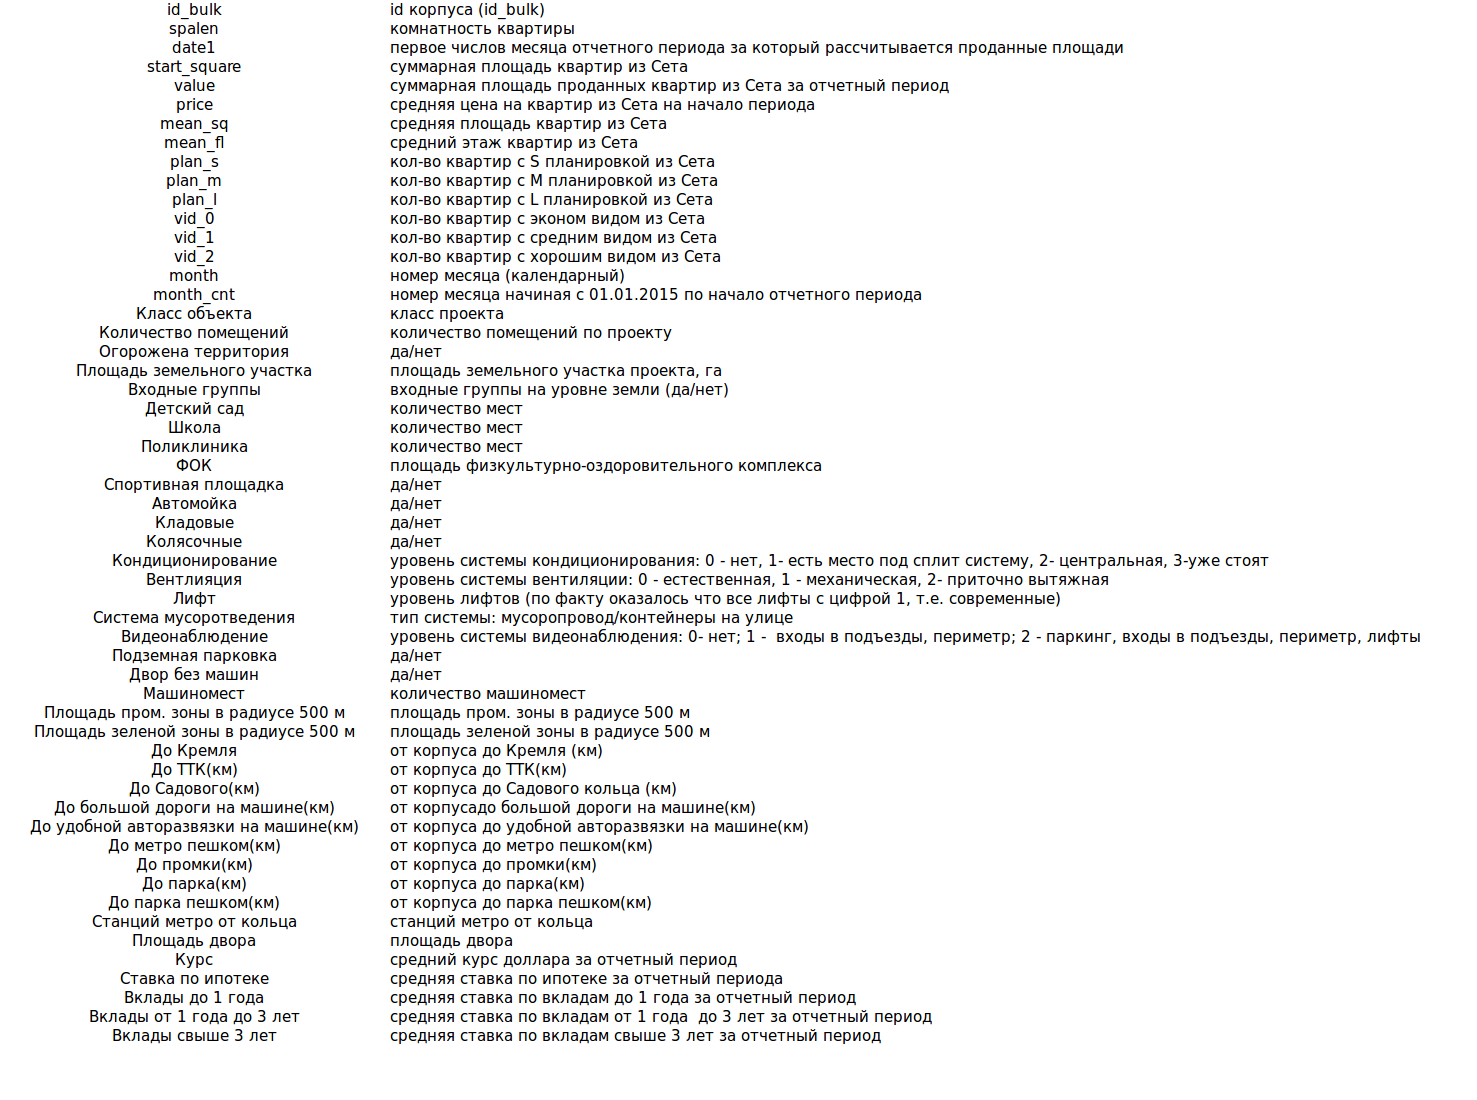

## Load

In [2]:
import pandas as pd, numpy as np

In [7]:
train = pd.read_csv('data/train.csv', index_col='id')
test = pd.read_csv('data/test.csv', index_col='id')

In [6]:
train.head()

,bulk_id,spalen,date1,start_square,value,price,mean_sq,mean_fl,plan_s,plan_m,...,До промки(км),До парка(км),До парка пешком(км),Станций метро от кольца,Площадь двора,Курс,Cтавка по ипотеке,Вклады до 1 года,Вклады от 1 года до 3 лет,Вклады свыше 3 лет
id,,,,,,,,,,,,,,,,,,,,,
0,FF3814A9-9F7D-E711-8530-00505688958B,1,2017-10-01,13109.9,1124.5,135633.913043,38.00,8,147,198,...,0.28,0.58,0.93,8.0,7640.0,57.698052,10.04,5.74,5.94,6.03
1,FF3814A9-9F7D-E711-8530-00505688958B,2,2017-10-01,19898.4,1412.3,128492.419825,58.01,9,139,120,...,0.28,0.58,0.93,8.0,7640.0,57.698052,10.04,5.74,5.94,6.03
2,FF3814A9-9F7D-E711-8530-00505688958B,0,2017-10-01,2100.0,345.0,158237.634409,22.58,10,78,15,...,0.28,0.58,0.93,8.0,7640.0,57.698052,10.04,5.74,5.94,6.03
3,FF3814A9-9F7D-E711-8530-00505688958B,3,2017-10-01,9614.9,769.4,123250.000000,78.81,8,50,0,...,0.28,0.58,0.93,8.0,7640.0,57.698052,10.04,5.74,5.94,6.03
4,FF3814A9-9F7D-E711-8530-00505688958B,1,2017-11-01,11947.2,526.7,139420.634921,37.93,9,140,175,...,0.28,0.58,0.93,8.0,7640.0,58.926552,9.87,5.17,7.07,6.20


In [8]:
test.head()

,bulk_id,spalen,date1,price,mean_sq,mean_fl,month,month_cnt,Класс объекта,Количество помещений,...,До промки(км),До парка(км),До парка пешком(км),Станций метро от кольца,Площадь двора,Курс,Cтавка по ипотеке,Вклады до 1 года,Вклады от 1 года до 3 лет,Вклады свыше 3 лет
id,,,,,,,,,,,,,,,,,,,,,
0,FF3814A9-9F7D-E711-8530-00505688958B,1,2018-02-01,144734.016393,37.97,9,2,38,эконом,1983,...,0.28,0.58,0.93,8.0,7640.0,56.806705,9.78,5.48,6.20,6.16
1,FF3814A9-9F7D-E711-8530-00505688958B,2,2018-02-01,136729.844961,57.78,9,2,38,эконом,1983,...,0.28,0.58,0.93,8.0,7640.0,56.806705,9.78,5.48,6.20,6.16
2,FF3814A9-9F7D-E711-8530-00505688958B,0,2018-02-01,167787.719298,23.21,10,2,38,эконом,1983,...,0.28,0.58,0.93,8.0,7640.0,56.806705,9.78,5.48,6.20,6.16
3,FF3814A9-9F7D-E711-8530-00505688958B,3,2018-02-01,132855.319149,79.39,9,2,38,эконом,1983,...,0.28,0.58,0.93,8.0,7640.0,56.806705,9.78,5.48,6.20,6.16
4,FF3814A9-9F7D-E711-8530-00505688958B,1,2018-03-01,147387.111111,37.99,9,3,39,эконом,1983,...,0.28,0.58,0.93,8.0,7640.0,57.063605,9.70,5.53,6.13,5.63


Предсказать для теста - start_square, plan_s, plan_m, plan_l, vid_0, vid_1, vid_2

## EDA

In [9]:
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline

In [14]:
def plot_duplicatesplot_dup (df):
    df = df.dropna(axis=1, thresh = 10)
    result = {col:df.duplicated([col]).sum() for col in df.columns}
    plt.figure(figsize=(4,10))
    plt.barh(list(result.keys()), list(result.values()), color='g', alpha=0.5)
    plt.show()

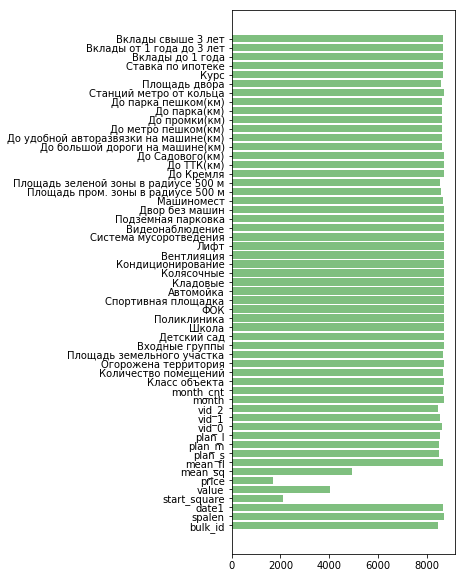

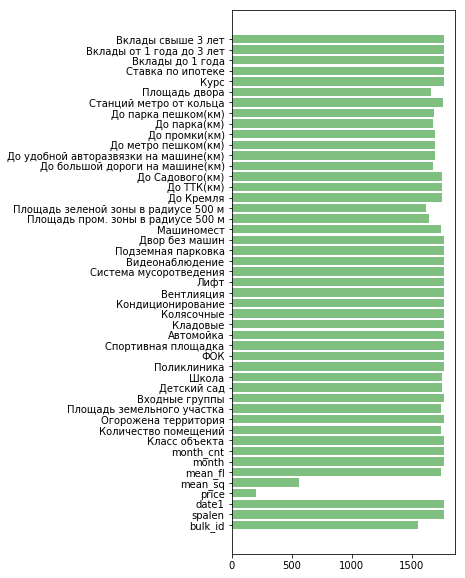

In [16]:
plot_duplicatesplot_dup(train)
plot_duplicatesplot_dup(test)

In [26]:
def val_count(df):
    for col in df.columns:
        print(df[col].value_counts(normalize=True).head(10), '\n')

In [27]:
val_count(train)

8B5D0C0E-C378-E511-B4A4-001EC9D5643C    0.015030
E435277C-002B-E511-82D8-001EC9D5643C    0.013768
D04F1379-5729-E511-84C6-001EC9D56418    0.013309
59BCC6D3-7204-E511-8C7F-001EC9D5643C    0.012965
67A58823-AFC9-E511-9405-001EC9D56418    0.012735
8B240E6D-7FCA-E511-9405-001EC9D56418    0.012620
8421806C-5D3E-E411-988B-001EC9D5643C    0.010899
C78A74B1-07DD-E411-9A07-001EC9D56418    0.010785
4B3B6D6A-93FF-E411-8098-001EC9D56418    0.010670
B526E7C2-5C3E-E411-988B-001EC9D5643C    0.010441
Name: bulk_id, dtype: float64 

1    0.273979
2    0.258261
3    0.234511
0    0.169803
4    0.063447
Name: spalen, dtype: float64 

2017-11-01    0.068036
2017-12-01    0.067233
2018-01-01    0.063905
2017-09-01    0.061381
2017-10-01    0.061152
2017-08-01    0.056333
2017-07-01    0.054842
2017-06-01    0.054153
2017-05-01    0.046925
2017-04-01    0.043254
Name: date1, dtype: float64 

87.50      0.003327
45.40      0.003212
44.18      0.003098
22.40      0.002065
455.00     0.001950
1493.70    0.0019

In [28]:
val_count(test)

999F708D-4FE9-E711-B9FF-00505688958B    0.008475
E806378B-4566-E711-97EC-001EC9D56418    0.008475
1AD77F71-D449-E711-97EC-001EC9D56418    0.008475
9D41BD52-F9BE-E711-BC64-00505688958B    0.008475
F10C7B44-9682-E711-8530-00505688958B    0.008475
460B6880-F8BE-E711-BC64-00505688958B    0.008475
EFE9999C-9576-E711-B07B-001EC9D5643C    0.008475
A0B7B63B-6DAF-E711-8547-00505688958B    0.008475
49A66B38-9682-E711-8530-00505688958B    0.008475
9A2B12C5-4566-E711-97EC-001EC9D56418    0.008475
Name: bulk_id, dtype: float64 

1    0.271751
2    0.266102
3    0.240113
0    0.146328
4    0.075706
Name: spalen, dtype: float64 

2018-04-01    0.349718
2018-03-01    0.330508
2018-02-01    0.319774
Name: date1, dtype: float64 

92000.0     0.004520
98000.0     0.003390
99000.0     0.003390
91000.0     0.003390
105000.0    0.003390
89000.0     0.002825
85000.0     0.002825
95500.0     0.002260
90100.0     0.002260
94500.0     0.002260
Name: price, dtype: float64 

39.80    0.005650
60.91    0.005085
22

In [29]:
train.nunique(dropna=False)

bulk_id                                   233
spalen                                      5
date1                                      31
start_square                             6596
value                                    4675
price                                    7019
mean_sq                                  3791
mean_fl                                    32
plan_s                                    201
plan_m                                    196
plan_l                                    185
vid_0                                     105
vid_1                                     186
vid_2                                     243
month                                      12
month_cnt                                  31
Класс объекта                               3
Количество помещений                       29
Огорожена территория                        2
Площадь земельного участка                 29
Входные группы                              2
Детский сад                       

In [32]:
test.nunique(dropna=False)

bulk_id                                   215
spalen                                      5
date1                                       3
price                                    1569
mean_sq                                  1205
mean_fl                                    31
month                                       3
month_cnt                                   3
Класс объекта                               3
Количество помещений                       29
Огорожена территория                        2
Площадь земельного участка                 29
Входные группы                              2
Детский сад                                21
Школа                                      16
Поликлиника                                 4
ФОК                                         2
Спортивная площадка                         1
Автомойка                                   2
Кладовые                                    2
Колясочные                                  2
Кондиционирование                 

In [33]:
def comare_df(df1, df2):
    for col in df1.columns:
        if col in df2.columns:
            ind = df1[col].isin(df2[col]) & df2[col].isin(df1[col])
            print(col, sum(ind))

In [34]:
comare_df(train, test)

bulk_id 1196
spalen 1770
date1 0
price 45
mean_sq 264
mean_fl 1769
month 361
month_cnt 0
Класс объекта 1770
Количество помещений 1770
Огорожена территория 1770
Площадь земельного участка 1770
Входные группы 1770
Детский сад 1770
Школа 1770
Поликлиника 1770
ФОК 1770
Спортивная площадка 1770
Автомойка 1770
Кладовые 1770
Колясочные 1770
Кондиционирование 1770
Вентлияция 1770
Лифт 1770
Система мусоротведения 1770
Видеонаблюдение 1770
Подземная парковка 1770
Двор без машин 1770
Машиномест 1770
Площадь пром. зоны в радиусе 500 м 1484
Площадь зеленой зоны в радиусе 500 м 1342
До Кремля 1770
До ТТК(км) 1770
До Садового(км) 1750
До большой дороги на машине(км) 1472
До удобной авторазвязки на машине(км) 1679
До метро пешком(км) 1713
До промки(км) 1716
До парка(км) 1674
До парка пешком(км) 1662
Станций метро от кольца 1770
Площадь двора 1389
Курс 0
Cтавка по ипотеке 0
Вклады до 1 года 0
Вклады от 1 года до 3 лет 0
Вклады свыше 3 лет 0
